<a href="https://colab.research.google.com/github/derek-shing/ML-Engineer-Exam/blob/main/ComputerVision/GanBasic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Conv2DTranspose, Reshape
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
#Load data
(train_image, train_label),(_,_) = tf.keras.datasets.mnist.load_data() #return (x_tranin, y_train),(x_test,y_test)

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
train_image.shape

(60000, 28, 28)

In [4]:
train_image = train_image.reshape(60000,28,28,-1).astype("float32")

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_image).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

**Define generoter model**

In [6]:
#3 convoluation transpose layers
# each follow by batch normalization and leaky RELU
# output is the image shape
def define_generator_model():
  model = tf.keras.Sequential()
  model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Reshape((7,7,256)))
  model.add(Conv2DTranspose(128, (5,5), strides=(1,1), use_bias=False, padding='same'))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(64, (5,5), strides=(2,2), use_bias=False, padding='same'))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(1, (5,5), strides=(2,2), use_bias=False, padding='same', activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)


  return model

In [7]:
#Try to see the out put of the model

generator = define_generator_model()
noise = tf.random.normal([1,100]) # 1 for 1D vector, 100 for 100 elements


In [8]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.47066373,  0.31187004,  0.12962814, -0.8910447 ,  0.87829006,
         2.1564746 ,  0.5003671 , -1.5835102 ,  0.4332993 , -0.38297945,
        -0.09065934, -0.27154422, -0.84918076, -2.560799  ,  0.21094143,
        -0.8150723 , -1.0014946 , -0.06094595, -2.13723   , -0.8400372 ,
        -0.34963188, -0.38195282, -0.7944577 ,  0.79381746, -0.9375652 ,
        -1.3664016 , -0.4541424 ,  1.6151131 ,  1.0054702 ,  1.5613974 ,
         0.5624213 , -0.88104254, -0.31816357,  0.06586623, -0.6490097 ,
         0.95623285, -0.7066538 ,  1.4487686 , -0.17286102,  0.86086553,
         0.6569681 , -0.28514504, -0.5139013 ,  0.56792444, -0.92258143,
         1.5559299 ,  0.40455583,  0.0484406 , -1.0520265 ,  0.7088624 ,
        -1.7756176 , -0.23412232,  0.07280674, -0.70131516, -0.6844044 ,
        -0.92261034, -0.6129388 , -1.4994164 , -1.1561174 , -1.3749927 ,
         1.1463535 , -1.5118538 ,  1.9556086 ,  0.42433634,  0.03557646,
 

In [9]:
generated_image = generator(noise, training=False)

In [10]:
generated_image.shape

TensorShape([1, 28, 28, 1])

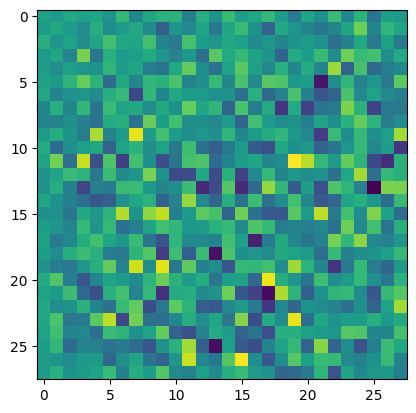

In [11]:
#show image
plt.imshow(generated_image[0,:,:,0])

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # Note the output is a single binary node

    return model

In [13]:
discriminator = make_discriminator_model()

**Define Loss function**

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def generator_loss(fake_output): #compare discrimintor 's output on fake image with 1, (Goal: want discriminator return 1 on fake image)
  return (cross_entropy(tf.ones_like(fake_output), fake_output))


In [16]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  return real_loss+fake_loss

**Define training step**

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [32]:

@tf.function
def train_step(image):
    noise = tf.random.normal([BATCH_SIZE, 100])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      gen_image = generator(noise, training = True)
      real_output = discriminator(image, training= True)
      fake_output = discriminator(gen_image, training = True)

      disc_loss = discriminator_loss(real_output, fake_output)
      gen_loss = generator_loss(fake_output)


    #use gradient tape to find the gradient using loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [19]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    print("train_step")
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    print("after with loop ")
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    print("after gradients")
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    print("after generator optimizer")
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    print("after discriminator optimizer")

In [20]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [36]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
      #print(time.time())
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [22]:
import os

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [34]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [26]:
from IPython import display

In [ ]:
train(train_dataset, EPOCHS)